# Merging classification results

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import evaluate
import merge
import load

In [2]:
# Load evaluation data
test_columns = ['returnQuantity', 'articleID', 'productGroup', 'customerID', 'voucherID']
test_predictions = merge.merged_predictions(test=True, keep_columns=test_columns)
test_train = evaluate.test_complement(test_predictions)

# Load classification data
class_columns = ['articleID', 'productGroup', 'customerID', 'voucherID']
class_predictions = merge.merged_predictions(keep_columns=class_columns)
class_train = load.orders_train()

## Confidences
### Imputation

Approximately 4% of predictions by team C have unknown confidences, making imputation necessary before merge approaches based on confidence can be applied. Because of this relatively small number, I propose to impute missing values using the mean confidence of Team C. The mean showed stable behavior across all splits in the test and prediction data.

### Comparison
Using approaches based on confidence implies comparison across classifiers. This is complicated by the different distributions of confidence, as depicted in the figure below.

In [3]:
# Violinplot for class data and evaluation data
def confidence_plot(class_data, evaluation_data):  
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
    ax1.set_title('Classification')
    ax = sns.violinplot(data=class_data['confidence'], ax=ax1)
    ax2.set_title('Evaluation')
    ax = sns.violinplot(data=evaluation_data['confidence'], ax=ax2)

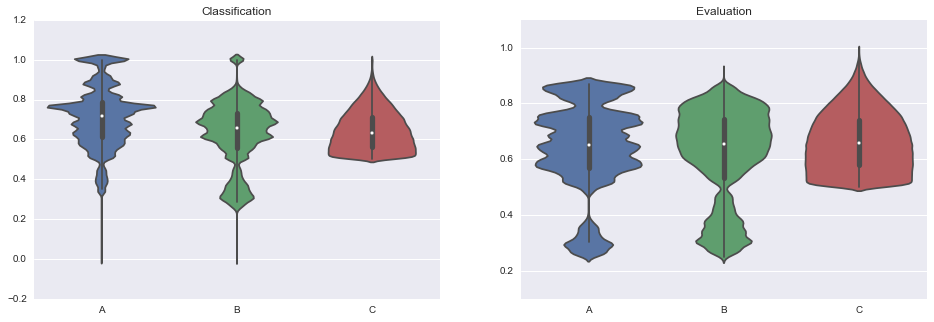

In [4]:
# Violinplot for original data
confidence_plot(class_predictions, test_predictions)

Instead of using the actual values, I propose to redefine the confidence in standard-deviations distance from the mean.

$$ conf_{i,c} = 1 + \frac{conf_{i,c} - \mu_c}{\sigma_c} * \frac{1}{max(conf_c)}$$

with $conf_{i,c}$ being the confidence of classification $c$ in row $i$. To confine the range in [-1, 1], the confidences for each classifier are divided by its maximum confidence. The center of the distributions is then moved to 1, making the confidences applicable as multiplier weights. NaN values are filled with ones (then representing the mean).

This approach centers the central tendencies at 1 and decreases the differences in the ranges by setting the standard deviations to 1.

The figure below shows the distributions of the imputed predictions.

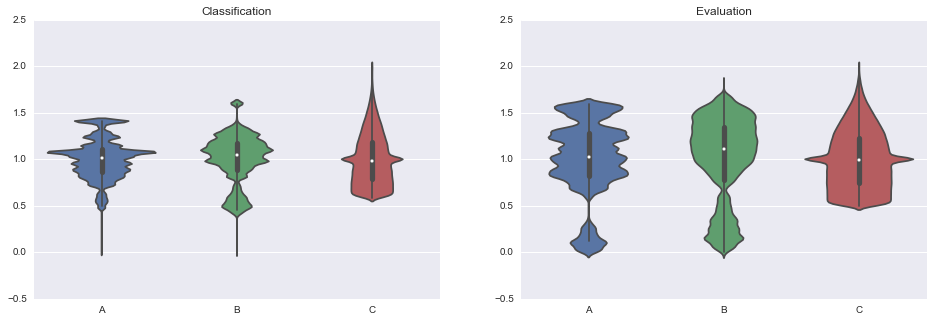

In [5]:
# Impute zeroes and convert confidenes to std-distances
class_imputed = merge.impute_confidence(class_predictions)
test_imputed = merge.impute_confidence(test_predictions)

# Violinplot for imputed data
confidence_plot(class_imputed, test_imputed)

## Approach 1: Naive Majority Vote
For each row, take the most common prediction. As we have 3 teams there is always a majority.

The naive majority vote assumes that each classifier is equally good and always equally confident. It uses relies on the least assumptions about performance evaluation and confidence comparability.

In [6]:
class_naive = merge.naive_majority_vote(class_imputed)
test_naive = merge.naive_majority_vote(test_imputed)

This approach can be evaluated on the test set; the result is shown in the figure below.

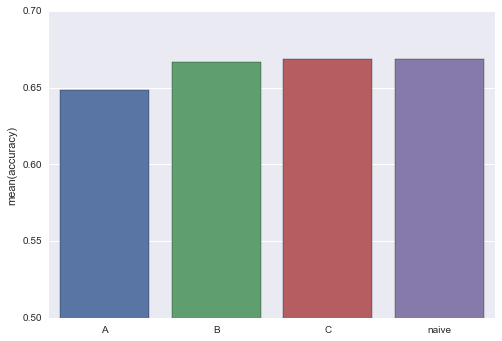

In [10]:
# Calculate mean accuracies
naive_mean_accuracies = evaluate.mean_accuracies(test_naive)

# Barplot
ax = sns.barplot(x=naive_mean_accuracies.index, y=naive_mean_accuracies['accuracy'])
lim = ax.set_ylim([0.5, 0.7])

The values are 64.85%, 66.66%, 66.86% and 66.89% in that order. The approach seems to yield a very small improvement compared to the best performing single team classification.

However, the new classification seems to resolve most of the arguments between the teams (cf. figure below). The naive merge seems to agree with teams A and C (under 1% distinct rows), while disagreeing mostly with team B (11%).

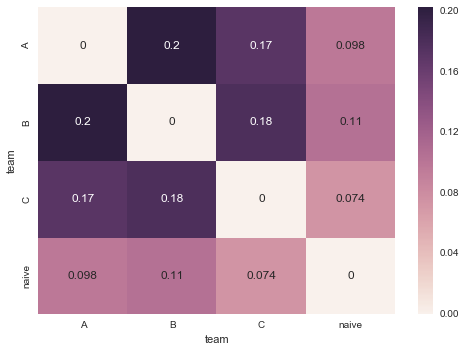

In [11]:
# Calculate difference for each combination
naive_differences = evaluate.distinct_predictions(class_naive)

# Heatmap
ax = sns.heatmap(naive_differences, annot=True)

The differences between the naive merge and team B go along with the differences team B had with other teams, the top four splits not present in the test set.

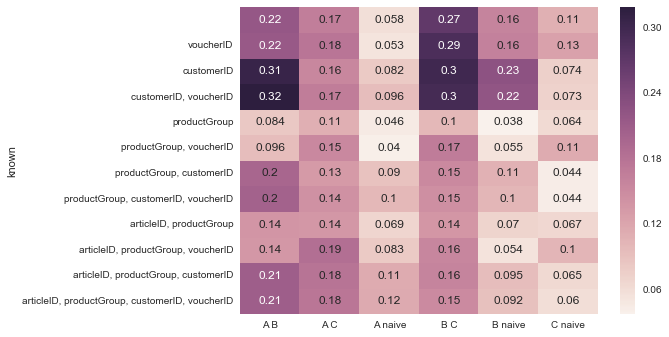

In [12]:
# Calculate differences across splits
naive_split_differences = evaluate.distinct_split_predictions(class_train, class_naive)

# Heatmap
ax = sns.heatmap(naive_split_differences, annot=True)

## Approach 2: Weighted Majority Vote

We use the following formula for the final $prediction_i$, with $i$ being the row index. In it, each $prediction_{c,i}$ of classifier $c$ is weighted.

$$
row_i =
\dfrac
    {\sum_{c \in C}
        prediction_{c,i}
        \cdot weight_{c,i}}
    {\sum_{c \in C} weight_{c,i}}
$$

The $weight_{c,i}$ takes into account the condfidence of $c$ in row $i$, the mean confidence of $c$ over all rows, the overall accuracy of $c$ and the mean accuracy of all classifiers.

$$
weight_{c,i} = \dfrac{confidence_{c,i}}{confidence_{c,\varnothing}} \cdot \bigg(\dfrac{accuracy_c}{accuracy_\varnothing}\bigg)^2
$$

The confidences returned by the classifiers are, as such, not comparable to each other. They differ in meaning and in range. To counteract and to avoid favoring classifiers that are generally -maybe mistakenly- confident, we take the confidence compared to the classifier's mean confidence.

The accuracy, we believe, is the best predictor of a classifier's performance in the target set. We take this information from a test set that each group used to evaluate their classifier. The test set is a 70/30 split of the training data. We compare the accuracy to the mean accuracy of all classifiers. As the difference tends to be big in information, but small in extent, the ratio is squared.

In [ ]:
weights = pd.Series([1,1,1], index=class_imputed['prediction'].columns)
test_weighted_confidence = merge.weighted_majority_vote(test_imputed, weights)
class_weighted_confidence = merge.weighted_majority_vote(class_imputed, weights)

In [ ]:
weights = evaluate.mean_accuracies(test_predictions)['accuracy']
test_weighted_accuracy = merge.weighted_majority_vote(test_imputed, weights)
class_weighted_accuracy = merge.weighted_majority_vote(class_imputed, weights)

## Approach 3: Avoiding disagreement

In [88]:
### Approach 4: Weighted Majority Vote based on plits